# Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

# POMDP from scratch

## Define POMDP components

In [2]:
states = np.array([0, 1])  # 0 = bear, 1 = bull

# Transition model: T[s, s']
T = np.array([
    [0.9, 0.1],   # bear
    [0.1, 0.9]    # bull
])

# Observation model parameters (returns)
obs_means = {0: -0.0005, 1: 0.0005}
obs_stds = {0: 0.01,   1: 0.01}

# Possible actions
ACTIONS = [-1, 0, 1]  # short, flat, long

## Define environment dynamics

In [3]:
def transition(state):
    """Sample next state from transition matrix."""
    return np.random.choice(states, p=T[state])


def observation(state):
    """Sample a noisy return from observation model."""
    return np.random.normal(obs_means[state], obs_stds[state])

## Belief update

In [4]:
def update_belief(belief, obs):
    """Bayesian belief update."""
    new_belief = np.zeros_like(belief)

    for s_prime in states:
        # likelihood of observation
        likelihood = (
            1 / (np.sqrt(2*np.pi)*obs_stds[s_prime]) *
            np.exp(-(obs - obs_means[s_prime])**2 / (2*obs_stds[s_prime]**2))
        )
        # total probability coming from all previous states
        prior = np.sum([T[s, s_prime] * belief[s] for s in states])
        
        new_belief[s_prime] = likelihood * prior

    # normalize
    new_belief /= np.sum(new_belief)
    return new_belief

## Simple action policy

In [8]:
def policy(belief):
    """
    Simple rule:
    - long si belief(bull) > 0.6
    - short si belief(bear) > 0.6
    - sinon flat
    """
    p_bear, p_bull = belief

    if p_bull > 0.5:
        return 1
    elif p_bear > 0.5:
        return -1
    return 0

## Simulation

In [6]:
def simulate(steps=200):
    state = np.random.choice(states)
    belief = np.array([0.5, 0.5])
    pnl = 0

    history = []

    for t in range(steps):
        obs = observation(state)
        belief = update_belief(belief, obs)
        act = policy(belief)
        
        # reward = action * true return
        reward = act * obs
        pnl += reward

        history.append({
            "state": state,
            "obs": obs,
            "belief_bear": belief[0],
            "belief_bull": belief[1],
            "action": act,
            "pnl": pnl
        })

        # environment evolves
        state = transition(state)

    return history

## Run

In [9]:
hist = simulate(300)

# Display a few steps to check
for h in hist[:10]:
    print(h)

{'state': 1, 'obs': 0.0037744284053828933, 'belief_bear': 0.4905650490702294, 'belief_bull': 0.5094349509297706, 'action': 1, 'pnl': 0.0037744284053828933}
{'state': 1, 'obs': 0.0015255227827126725, 'belief_bear': 0.4886396143367561, 'belief_bull': 0.5113603856632439, 'action': 1, 'pnl': 0.005299951188095566}
{'state': 1, 'obs': -0.005045176654822666, 'belief_bear': 0.5035235736830668, 'belief_bull': 0.4964764263169333, 'action': -1, 'pnl': 0.01034512784291823}
{'state': 1, 'obs': 0.014180221099457366, 'belief_bear': 0.4674145866367668, 'belief_bull': 0.5325854133632332, 'action': 1, 'pnl': 0.024525348942375597}
{'state': 1, 'obs': 0.01642591789472067, 'belief_bear': 0.4332441621943202, 'belief_bull': 0.5667558378056797, 'action': 1, 'pnl': 0.04095126683709627}
{'state': 1, 'obs': -0.006720915458470951, 'belief_bear': 0.46325947397852246, 'belief_bull': 0.5367405260214776, 'action': 1, 'pnl': 0.03423035137862532}
{'state': 1, 'obs': 0.02055677236839175, 'belief_bear': 0.419878272337713

In [ ]:
hist

# POMDP using HMM

In [52]:
from hmmlearn.hmm import GaussianHMM

## Generate synthetic Datas

In [ ]:
def generate_returns(n=1000):
    """
    Génère une série de returns avec deux régimes :
    - Regime 0 = bear (neg mean, high vol)
    - Regime 1 = bull (pos mean, low vol)
    """
    regimes = np.zeros(n, dtype=int)
    rets = np.zeros(n)

    # transitions réalistes
    T = np.array([
        [0.95, 0.05],
        [0.05, 0.95]
    ])

    state = 1  # start in bull

    for t in range(n):
        regimes[t] = state
        
        if state == 0:
            rets[t] = np.random.normal(-0.001, 0.01)
        else:
            rets[t] = np.random.normal(0.0005, 0.005)

        state = np.random.choice([0, 1], p=T[state])

    return rets.reshape(-1, 1), regimes

## Fit the model

In [54]:
def fit_hmm(returns, n_states=2):
    scale = 100
    X = returns * scale

    hmm = GaussianHMM(
        n_components=2,
        covariance_type="full",
        n_iter=2000,
        tol=1e-3,
        init_params="mc"
    )
    
    hmm.means_ = np.array([[-0.05], [0.05]])  # plus separation
    hmm.covars_ = np.array([[[0.01]], [[0.01]]])  # réduire variance initiale

    hmm.startprob_ = np.array([0.5, 0.5])
    hmm.transmat_ = np.array([
        [0.95, 0.05],
        [0.05, 0.95]
    ])

    hmm.fit(X)
    return hmm

## Define trading policy

In [55]:

def trading_policy(state_probs):
    """
    state_probs = array([p(bear), p(bull)])
    """
    if state_probs[1] > 0.5:
        return 1      # long bull
    elif state_probs[0] > 0.5:
        return -1     # short bear
    return 0          # no position


## Simulate actions

In [56]:
def simulate_trading(returns, state_probas):
    pnl = 0
    pnl_series = []

    for ret, probs in zip(returns, state_probas):
        action = trading_policy(probs)
        pnl += action * ret
        pnl_series.append(pnl)

    return np.array(pnl_series)

## Run the simulation

In [57]:
returns, true_states = generate_returns(1500)
hmm = fit_hmm(returns)

# filtered probabilities: p(s | r_1, ..., r_t)
probas = hmm.predict_proba(returns)

pnl_series = simulate_trading(returns, probas)

Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


In [58]:
pnl_series

array([[-0.1516069],
       [-0.1516069],
       [-0.1516069],
       ...,
       [-0.1516069],
       [-0.1516069],
       [-0.1516069]])

## Visualize

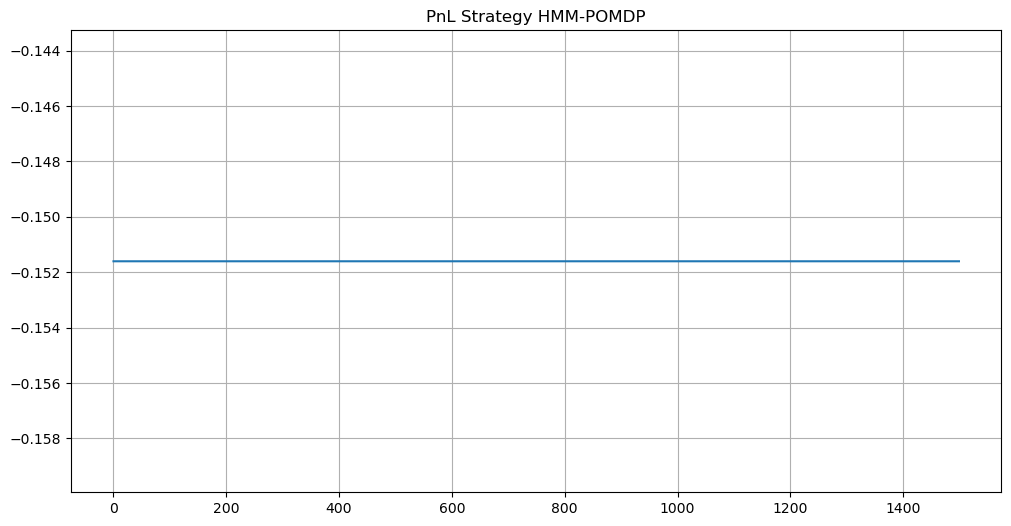

In [59]:
plt.figure(figsize=(12,6))
plt.plot(pnl_series)
plt.title("PnL Strategy HMM-POMDP")
plt.grid()
plt.show()

In [60]:
print(probas[:10])

[[5.12385207e-12 1.00000000e+00]
 [1.27712793e-04 9.99872287e-01]
 [1.88394822e-04 9.99811605e-01]
 [2.16574528e-04 9.99783425e-01]
 [2.29442282e-04 9.99770558e-01]
 [2.35676208e-04 9.99764324e-01]
 [2.38680530e-04 9.99761319e-01]
 [2.40704691e-04 9.99759295e-01]
 [2.41462366e-04 9.99758538e-01]
 [2.42303225e-04 9.99757697e-01]]


In [61]:
print("means:", hmm.means_)
print("covars:", hmm.covars_)

means: [[-0.0829205 ]
 [ 0.06637099]]
covars: [[[1.11339437]]

 [[0.24790151]]]
